### Install dependencies


In [1]:
!pip install --upgrade pandas_datareader
%pip install py_vollib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd, datetime as dt, numpy as np
from pandas_datareader import data as pdr
import matplotlib as plt 
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta
import yfinance as yf

### Import data 

In [3]:
start = dt.datetime(2020,1,1)
end = dt.datetime.now()

df = yf.download('CBA.AX', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


### Prep data

(Ticker
 CBA.AX    0.270309
 Name: 2025-01-16 00:00:00, dtype: float64,
 Ticker
 CBA.AX    155.75
 Name: 2025-01-16 00:00:00, dtype: float64)

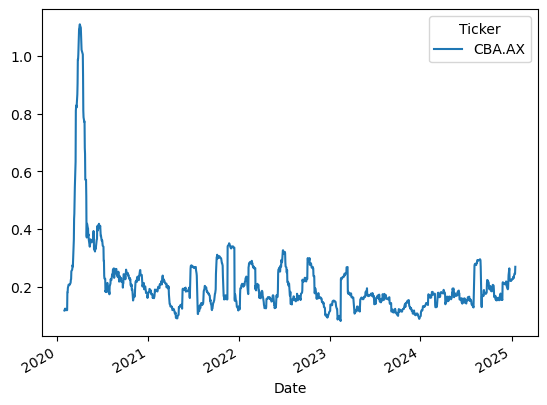

In [17]:
Close = df['Close']
Close.tail()

log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
TRADING_DAYS = 20
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)

volatility.plot()
volatility.iloc[-1], Close.iloc[-1]

### Calculate implied volatility    

In [19]:
def implied_volatility(S0, K, T, r, market_price, flag='c', tol = 0.00001):
    """ For european option. Refine volatility until calculated bs price reaches 
    market price within a small tolerance level.

    :param S0: stock price
    :K: strike price
    :T: time to maturity
    :r: risk free rate
    :market_price: option price in market
    """

    max_iter = 200
    vol_old = 0.1 # initial guess

    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price

        vol_new = vol_old - C/Cprime # based on price difference
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price - market_price) < tol):
            break
    
        vol_old = vol_new

    implied_volatility = vol_new
    return implied_volatility

### Calculation for ATM options across different expiries

In [25]:
S0 = 102
atm_options = [
    [dt.date(2021,10,18), 102, [2.585, 3.25], [4.6, 5.3]],
]
call_bids, call_asks, put_bids, put_asks = [],[],[],[]
IV_DTE = []

for i in atm_options:
    date, K = i[0], i[1]
    DTE = (date - dt.date(2021, 7, 30)).days
    T = DTE/365
    r = 0.02
    call_bid, call_ask = i[2]
    put_bid, put_ask = i[3]

    call_bids.append(implied_volatility(S0, K, T, r, call_bid, flag='c')*100)
    call_asks.append(implied_volatility(S0, K, T, r, call_ask, flag='c')*100)
    put_bids.append(implied_volatility(S0, K, T, r, put_bid, flag='p')*100)
    put_asks.append(implied_volatility(S0, K, T, r, put_ask, flag='p')*100)
    IV_DTE.append(DTE)

call_bids, call_asks, put_bids, put_asks


([12.391744243113061],
 [15.89983054184741],
 [25.370308271406177],
 [29.062481076021502])

### Option Pricing Setup for Multi-Week Scenario

In [26]:
K = 102
N = 11 # 11 weeks
sigma = 0.3 # vol
S0 = 102
DTE = (dt.date(2021,10,10) - dt.date(2021,7,30)).days
T = DTE/365
r = 0.02
DT=T/N # time step each week
TTE = [DT*N - DT*i for i in range(0,N+1)] # time to expiration for each week

### Delta calculation and adjustment functions

In [27]:
def calc_delta(flag, price, K, time, r, sigma, position='s'):
    if time == 0: return np.nan
    else:
        if position == 'l':
            return int(delta(flag, price, K, time, r, sigma)*100)
        else:
            return -int(delta(flag, price, K, time, r, sigma)*100)

def adjust(delta, total):
    """
    Adjusts option hedge to ensure delta neutrality.
    """
    if delta < 0:
        return 'Buy {0}'.format(abs(delta))
    elif delta < 0:
        return 'Sell {0}'.format(abs(delta))
    elif delta == 0:
        return None
    else:
        if total < 0:
            return 'Sell {0}'.format(abs(total))
        elif total > 0:
            return 'Buy {0}'.format(abs(total))
        else:
            return np.nan
        

def totalAdj(counter, time):
    """
    Provides total position after adjustment. 
    Whether net long or short and by how much.
    """

    if time > 0:
        if counter < 0:
            return 'Long {0}'.format(abs(counter))
        elif counter > 0:
            return 'Short {0}'.format(abs(counter))
        else: 
            return np.nan
    else:
        return np.nan
        

def cashAdj(delta, price, time, total):
    """
    Wherther adjustment happens during option lifetime or at expiry.
    """
    if time > 0:
        return delta*price
    else:
        return -total*price



### Dynamic Hedging simulation

In [28]:
Dynamic_heding_results = pd.DataFrame(data=[], columns=[], index=['Original Option P&L', 'Original Stock P&L', 'Adjustment P&L, Carry (interest) on options', 'Carry (interset) on stock', 'Interest on Adjustments'])

Dynamic_heding_results.index.name = 'Dynamic Hedging Results'

call_bid, call_ask, put_bid, put_ask = 2.585, 3.25, 4.6, 5.3

M = 1000 # number of test

sigma = 0.12 # realized vol

# position in option contract
k = 102
position = 's'
flag = 'c'